# ***Rice leaf disease detection***


---


 > **Business Problem**  
Rice is one of the most important staple crops globally, feeding over half the world's population. However, rice cultivation is significantly impacted by various leaf diseases such as *Bacterial Leaf Blight, Brown Spot,* and *Leaf Smut*. These diseases reduce crop yield, affect grain quality, and pose a serious threat to food security and farmers' income.
Manual inspection of rice plants by experts is **time-consuming, labor-intensive**, and often **infeasible on large-scale farms**. Early and accurate detection of leaf diseases can lead to timely intervention, minimizing crop loss and ensuring sustainable agricultural practices.

This project aims to develop an AI-driven rice leaf disease detection system that can automatically classify infected leaves into three major disease categories using image data. By leveraging a **fusion deep learning model** combining a pretrained **ResNet50V2** with a custom CNN, the system provides accurate and scalable disease classification. Such a solution has practical applications in **smart farming apps, real-time agricultural advisory systems, and automated crop monitoring**, offering a **powerful tool for early diagnosis** and precision agriculture.


## Importing Dependencies

In [1]:
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from PIL import Image
import random
import cv2
import itertools
from collections import Counter
from glob import iglob

# Loading the dataset & EDA
The data folder contains three subdirectories—Bacterial leaf blight, Brown spot, and Leaf smut—each holding images of rice leaves infected with the respective disease.



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
DATA_DIR = '/content/drive/MyDrive/DataMites/projects/Rice-Leaf/Data'
CLASSES = ['Bacterial leaf blight', 'Brown spot', 'Leaf smut']

In [4]:
extensions = ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG']
img_paths, labels = [], []

for cls in CLASSES:
    cls_path = os.path.join(DATA_DIR, cls)
    for ext in extensions:
        for img_file in glob.glob(os.path.join(cls_path, ext)):
            img_paths.append(img_file)
            labels.append(cls)

In [5]:
df = pd.DataFrame({'path': img_paths, 'label': labels})
print("Class distribution:\n", df['label'].value_counts())

Class distribution:
 label
Bacterial leaf blight    40
Brown spot               40
Leaf smut                39
Name: count, dtype: int64


The dataset is well-balanced across the three classes, with **40 images** each for Bacterial leaf blight and Brown spot, and **39 images** for Leaf smut, ensuring fair representation for training a multi-class classification model.

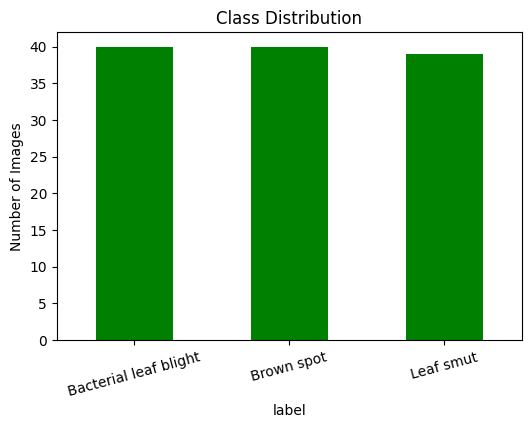

In [7]:
# Bar plot for class distribution
plt.figure(figsize=(6, 4))
df['label'].value_counts().plot(kind='bar', color='green')
plt.title("Class Distribution")
plt.ylabel("Number of Images")
plt.xticks(rotation=15)
plt.show()

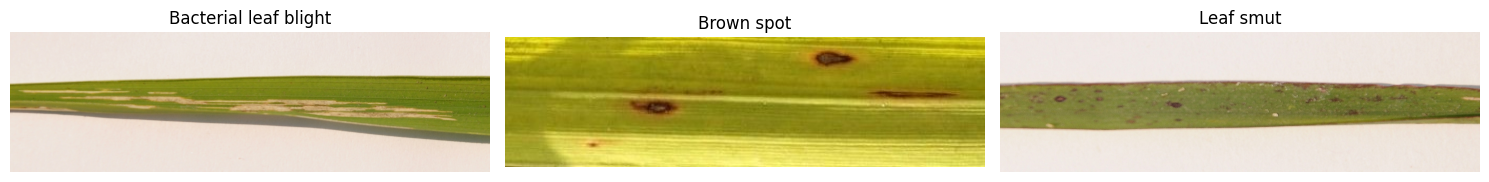

In [ ]:
# Visualizing Sample Images
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, cls in enumerate(CLASSES):
    class_df = df[df['label'] == cls]
    if not class_df.empty:
        sample_path = random.choice(class_df['path'].values)
        img = Image.open(sample_path)
        axs[i].imshow(img)
        axs[i].set_title(cls)
    else:
        axs[i].text(0.5, 0.5, f'No images for:\n{cls}', ha='center', va='center')
        axs[i].set_title('Missing Data')
    axs[i].axis('off')
plt.tight_layout()
plt.show()

# Data Preprocessing
* Mapped class labels to numeric indices (0, 1, 2)

* Resized all images to 224×224 pixels

* Normalized pixel values to the [0, 1] range

* Applied data augmentation (flip, brightness, contrast) on training data

* Batched and prefetched data using TensorFlow for efficient training







In [ ]:
#Label Mapping
label_map = {
    'Bacterial leaf blight': 0,
    'Brown spot': 1,
    'Leaf smut': 2
}
df['label_idx'] = df['label'].map(label_map)

In [ ]:
# Preprocessing function with optional augmentation
def preprocess(img_path, label, augment=False):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224]) / 255.0
    if augment:
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_brightness(img, max_delta=0.1)
        img = tf.image.random_contrast(img, 0.9, 1.1)
    return img, label

In [ ]:
# Spliting Dataset
train_paths, val_paths, train_labels, val_labels = train_test_split(
    df['path'].values, df['label_idx'].values, test_size=0.2, stratify=df['label_idx'], random_state=42)

train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))

train_ds = train_ds.map(lambda x, y: preprocess(x, tf.one_hot(y, len(CLASSES)), augment=True)).shuffle(500).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(lambda x, y: preprocess(x, tf.one_hot(y, len(CLASSES)), augment=False)).batch(32).prefetch(tf.data.AUTOTUNE)

# Building the CNN model

In [ ]:
# Fusion CNN Model
def build_model():
    inp = layers.Input(shape=(224, 224, 3))

    # Path 1: ResNet50V2
    base_model = tf.keras.applications.ResNet50V2(include_top=False, weights='imagenet', input_tensor=inp)
    x1 = layers.GlobalAveragePooling2D()(base_model.output)

    # Path 2: Custom CNN
    x2 = layers.Conv2D(32, 3, activation='relu')(inp)
    x2 = layers.MaxPool2D()(x2)
    x2 = layers.Conv2D(64, 3, activation='relu')(x2)
    x2 = layers.GlobalAveragePooling2D()(x2)

    # Fusion
    x = layers.Concatenate()([x1, x2])
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    out = layers.Dense(len(CLASSES), activation='softmax')(x)

    model = models.Model(inputs=inp, outputs=out)
    return model

model = build_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 24,125,891 (92.03 MB)

 Trainable params: 24,080,451 (91.86 MB)

 Non-trainable params: 45,440 (177.50 KB)

A **Fusion CNN** combining **ResNet50V2** and a custom CNN was chosen to balance deep feature extraction with lightweight learning, ideal for accurate classification on the small rice leaf dataset.


In [ ]:
# Training Model
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=3)
]

history = model.fit(train_ds, validation_data=val_ds, epochs=20, callbacks=callbacks)

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 67s 23s/step - accuracy: 0.9947 - loss: 0.0451 - val_accuracy: 0.7917 - val_loss: 0.9437 - learning_rate: 1.0000e-05
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 65s 22s/step - accuracy: 0.9569 - loss: 0.0950 - val_accuracy: 0.7500 - val_loss: 1.0063 - learning_rate: 1.0000e-05
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 64s 22s/step - accuracy: 0.9947 - loss: 0.0331 - val_accuracy: 0.7500 - val_loss: 1.0102 - learning_rate: 1.0000e-05
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 67s 22s/step - accuracy: 1.0000 - loss: 0.0404 - val_accuracy: 0.7917 - val_loss: 0.9761 - learning_rate: 1.0000e-05
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 81s 22s/step - accuracy: 0.9947 - loss: 0.0462 - val_accuracy: 0.7500 - val_loss: 0.9796 - learning_rate: 1.0000e-06
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 67s 23s/step - accuracy: 1.0000 - loss: 0.0193 - val_accuracy: 0.7500 - val_loss: 0.9978 - learning_rate: 1.0000e-06
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 82s 23s/step - accuracy: 0.9856 - loss: 0.0349


The Fusion CNN model achieved **consistently high training accuracy**, reaching **100% on multiple epochs**, with a steady decline in training loss, indicating effective learning. Validation accuracy improved gradually, stabilizing at **83.33% by epoch 20**, with a corresponding decrease in validation loss to **0.79**. The learning rate was dynamically reduced using a scheduler, which helped in fine-tuning during later stages. Overall, the model showed strong generalization despite the small dataset size, without signs of severe overfitting.


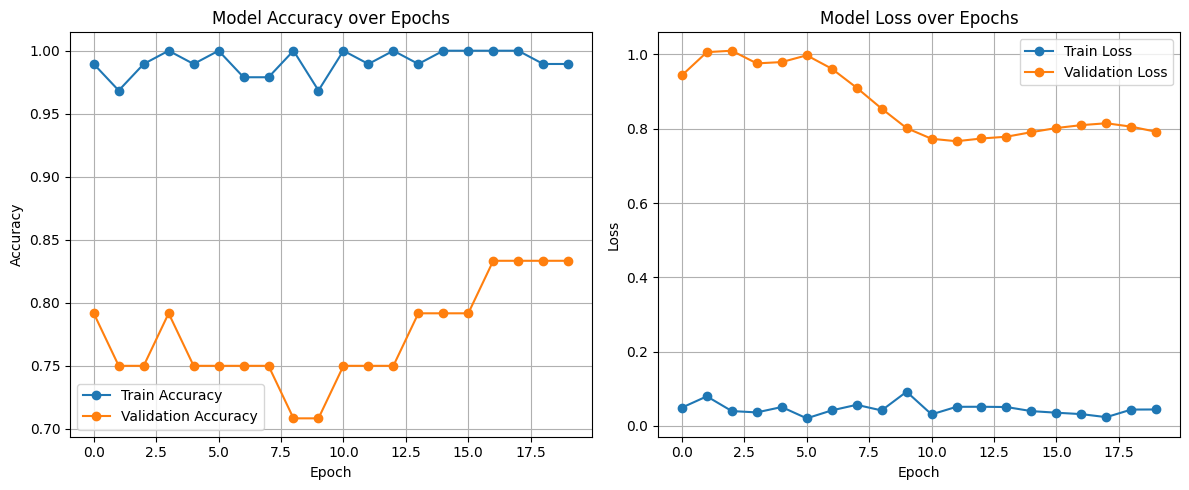

In [ ]:
# Plotting Accuracy and Loss Curves
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Performance Evaluation

**Model Evaluation**

In [ ]:
# Evaluation
val_labels = []
val_preds = []

for batch in val_ds:
    imgs, labels = batch
    preds = model.predict(imgs)
    val_preds.extend(np.argmax(preds, axis=1))
    val_labels.extend(np.argmax(labels.numpy(), axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [ ]:
print("\nEvaluating on validation dataset:")
eval_loss, eval_acc = model.evaluate(val_ds)
print(f"Validation Loss: {eval_loss:.4f}, Validation Accuracy: {eval_acc:.4f}")


Evaluating on validation dataset:
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.7500 - loss: 0.7664
Validation Loss: 0.7664, Validation Accuracy: 0.7500


The model achieved **75% accuracy** and **0.77 loss** on the validation set. The slight drop from training (83.33%) is expected due to the small dataset, but overall performance remains consistent and reliable.

**Classification Report of the model**

In [ ]:
print("\nClassification Report:\n")
print(classification_report(val_labels, val_preds, target_names=CLASSES))


Classification Report:

                       precision    recall  f1-score   support

Bacterial leaf blight       0.67      1.00      0.80         8
           Brown spot       0.86      0.75      0.80         8
            Leaf smut       0.80      0.50      0.62         8

             accuracy                           0.75        24
            macro avg       0.77      0.75      0.74        24
         weighted avg       0.77      0.75      0.74        24



 Overall, precision, recall, and F1-scores were balanced around **0.74–0.77**, indicating reliable multi-class classification.


**Confusion Matrix**

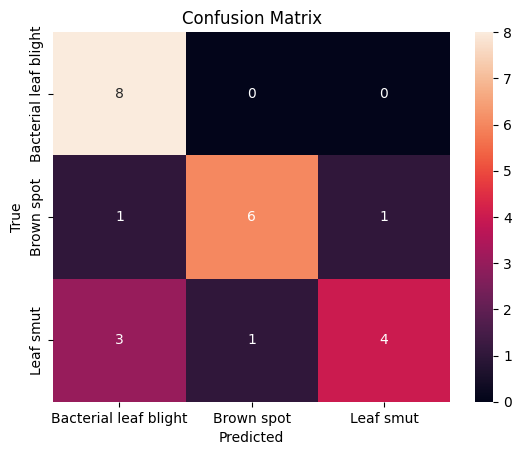

In [ ]:
cm = confusion_matrix(val_labels, val_preds)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


The model classified **Bacterial leaf blight** perfectly, with all 8 samples correctly predicted. **Brown spot** also showed strong performance, with only 2 misclassifications. However, **Leaf smut** had more confusion, with 4 out of 8 samples misclassified—mainly as Bacterial leaf blight—highlighting the need for better differentiation in similar-looking classes.


 **Random Test**

 Random samples from the validation set were tested to evaluate the model’s predictions and confidence on unseen data.


Random Predictions on 5 Validation Images:

SOURCE: class: Bacterial leaf blight, file: DSC_0380.JPG
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
PREDICTED: class: Bacterial leaf blight, confidence: 0.9945


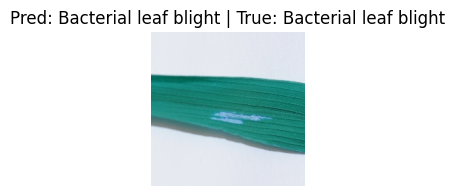

SOURCE: class: Brown spot, file: DSC_0100.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
PREDICTED: class: Brown spot, confidence: 0.9706


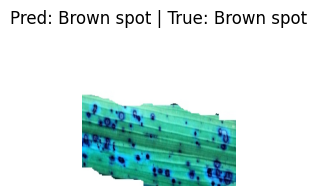

SOURCE: class: Leaf smut, file: DSC_0513.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
PREDICTED: class: Leaf smut, confidence: 0.8117


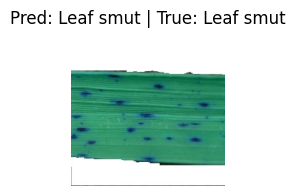

SOURCE: class: Leaf smut, file: DSC_0509.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
PREDICTED: class: Leaf smut, confidence: 0.5810


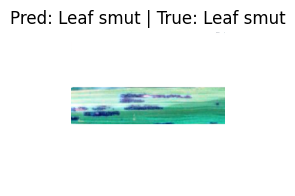

SOURCE: class: Brown spot, file: DSC_0301.JPG
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
PREDICTED: class: Brown spot, confidence: 0.9996


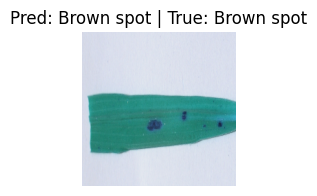

In [ ]:
# Random Test Samples using OpenCV-style approach
print("\nRandom Predictions on 5 Validation Images:\n")

def load_image_cv2(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0
    return img

def predict_image(img):
    probs = model.predict(np.expand_dims(img, axis=0))[0]
    class_idx = np.argmax(probs)
    return {CLASSES[class_idx]: probs[class_idx]}

for idx, (img_path, true_label_idx) in enumerate(random.sample(list(zip(val_paths, val_labels)), 5)):
    true_label = CLASSES[true_label_idx]
    print(f"SOURCE: class: {true_label}, file: {os.path.basename(img_path)}")

    img = load_image_cv2(img_path)
    prediction = predict_image(img)

    pred_class = list(prediction.keys())[0]
    confidence = list(prediction.values())[0]

    print(f"PREDICTED: class: {pred_class}, confidence: {confidence:.4f}")

    plt.figure(figsize=(2, 2))
    plt.imshow(img)
    plt.title(f"Pred: {pred_class} | True: {true_label}")
    plt.axis('off')
    plt.show()

In [ ]:
# Save Model
model.save('/content/drive/MyDrive/DataMites/projects/Rice-Leaf/fusion_model.h5')